# GRADIENT DESCENT

## Imports, function definitions, and data splitting

#### Useful functions 

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

# modified gaussian_mech_zCDP_vec to do the gaussian mech on a value with rho (zCDP) instead of alpha, epsilon_bar (RDP) 
def gaussian_mech_zCDP(v, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return v + np.random.normal(loc=0, scale=sigma)
    
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]
    
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

# function written for homework 9, approximates rho based on input epsilon and delta
def approximate_rho(epsilon, delta):
    # threshold is how close we want to be
    threshold = 0.01
    # pick an arbitrary original rho
    rho = 1
    # loop until we get under the threshold
    while (True):
        # compute epsilon based on our estimated rho and the input values
        computed_epsilon = rho + 2 * np.sqrt(rho * np.log(1 / delta))
        # compute the difference between them and take the absval to get the actual distance from goal
        epsilon_difference = np.abs(computed_epsilon - epsilon)
        # if our difference is under the threshold, return rho, we found it
        if epsilon_difference < threshold:
            return rho
        # if our computed epsilon is less than the desired, increase rho by 10%
        if (epsilon > computed_epsilon):
            rho *= 1.1
        # if our computed epsilon is greater than the desired, decrease rho by 10%
        elif (epsilon < computed_epsilon):
            rho *= 0.9

#### Import the frisbee dataset, drop sensitive and irrelevant columns, one-hot encode categorical columns, and make a label column for the model

In [4]:
# import the frisbee dataset
frisbee = pd.read_csv('https://raw.githubusercontent.com/jbellizia/cs-3110-final/refs/heads/main/ultimate_college_championship.csv')

# discard player names and team names, as well as plus minus per game (we use plus minus kind of in the gradient descent)
frisbee = frisbee.drop(['player', 'team_name', 'pls_mns_per_game'], axis = 1)

# one hot encode the categorical columns 
frisbee = pd.get_dummies(frisbee, columns=['level', 'gender', 'division'], drop_first = True).astype(int)

# add a categorical 'is_positive' column that we will be testing on
# -1 if plus_minus is negative
# 1 if plus_minus is positive
# this way, we can use classification to predict a player's value on a team based on their stats
# this evaluates if a players plus minus is positive and stores the truth value as an integer (-1 or 1)
# at first, i used 0 and 1, but i think that wasn't strong enough for the model
frisbee['is_positive'] = (frisbee['plus_minus'] > 0).astype(int)
frisbee['is_positive'] = frisbee['is_positive'] * 2 - 1

#### Randomize frisbee for testing and training, then split into X (features) and y (labels). Then split into training data and test data.

In [3]:
# shuffle frisbee so there is no ordering by plus_minus (there is in the original)
frisbee = frisbee.sample(frac = 1)

# now, assign the features and labels to X and y

# X is frisbee with all the features and not the labels
X = frisbee.drop(['is_positive', 'plus_minus'], axis = 1)

# y is frisbee but just the label is_positive
y = frisbee['is_positive']

# pulled straight from exercise, assign the training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size].to_numpy()
X_test = X[training_size:].to_numpy()

y_train = y[:training_size].to_numpy()
y_test = y[training_size:].to_numpy()


# function to reshuffle all of the above, which should be called before each repeated run of descent to avoid repeated training data
# basically, re sample so we dont get insanely good training on the same data, and return the re sample
def re_shuffle(df):
    frisbee = df.sample(frac = 1)
    X = frisbee.drop(['is_positive', 'plus_minus'], axis = 1)
    y = frisbee['is_positive']
    training_size = int(X.shape[0] * 0.8)
    
    X_train = X[:training_size].to_numpy()
    X_test = X[training_size:].to_numpy()
    
    y_train = y[:training_size].to_numpy()
    y_test = y[training_size:].to_numpy()

    return X_train, X_test, y_train, y_test

## Gradient descent functions

#### Pull gradient descent functions from Exercise 10-27, for use in both non-DP gradient descent and later analysis

In [4]:

# Since we are doing classification as we were in the exercise, we use the logistic loss function, or cross-entropy function 
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

# define the gradient - the rate of change of loss in each direction
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

# define the average gradient for all training instances
def avg_grad(theta, X, y):
    grads = [gradient(theta, x_i, y_i) for x_i, y_i in zip(X, y)]
    avg_gradient = np.mean(grads, axis=0)
    return avg_gradient

# function to average the loss over all training instances over a given iteration
def avg_loss(theta, X, y):
    return np.average([loss(theta, X[i], y[i]) for i in range(len(X))])

# function to perform iterations of gradient descent
def gradient_descent(iterations):
    theta = np.zeros(X_train.shape[1])
    # add tracking for losses over iterations so we can plot
    losses = []
    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)
        # this adds the average loss for a given iteration over all training instances
        losses.append(avg_loss(theta, X_train, y_train))
    return theta, losses

# predicts label based on example xi
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

# define accuracy, slightly different from in class so that we can vary test data per run (not leakage, just for averaging accuracy)
def accuracy(theta, X_test, y_test):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]
    
# take an average of the accuracy of many descents (takes a minute for iterations > 50)
def accuracy_average_non_DP(trials, gradient_iterations):
    average_accuracy = 0
    for _ in range(trials):
        # shuffle the data on every trial so that we get accuracy over the whole data set, not just on a particular split
        X_train, X_test, y_train, y_test = re_shuffle(frisbee)
        theta, losses = gradient_descent(gradient_iterations)
        average_accuracy += accuracy(theta, X_test, y_test)
    return average_accuracy / trials

theta, losses = gradient_descent(20)
accuracy(theta, X_test, y_test)

# (50 instances of gradient descent, 15 steps each)
print(accuracy_average_non_DP(50, 15))

0.9667267267267269


#### Implement noisy gradient descent for zero concentrated DP

In [5]:
# helper functions:
# L2 clipping of vectors, used for zCDP  gradient descent
def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)
    if norm > b:
        return b * (v / norm)
    else:
        return v

# L2 clips the gradient for all the training instances
def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]
    return np.sum(gradients, axis=0)

# function that performs noisy gradient descent
def gradient_descent_zCDP(iterations, rho):
    # make empty theta
    theta = np.zeros(X_train.shape[1])
    # after a few experiments, found that b = 15 was the best.. seems high but the data has high values and i didnt want to normalize
    # as finding the max was not dp friendly
    b = 15
    # divvy up our rho
    rho_i = rho / (iterations + 1)
    # get count and add noise
    noisy_count = gaussian_mech_zCDP(X_train.shape[0], 1, rho_i)
    # remember losses at each iteration 
    losses = []
    # iterate descent
    for i in range(iterations):
        # clip the gradient
        clipped_gradient_sum = gradient_sum(theta, X_train, y_train, b)
        # add noise (rho_i per iteration)
        noisy_gradient_sum = np.array(gaussian_mech_zCDP_vec(clipped_gradient_sum, b, rho_i))
        # normalize according to noisy count
        noisy_avg_gradient = noisy_gradient_sum / noisy_count
        theta = theta - noisy_avg_gradient
        # this adds the average loss for a given iteration over all training instances
        losses.append(avg_loss(theta, X_train, y_train))
    return theta, losses


## Testing

#### Testing for zCDP gradient descent, including an average accuracy function 

In [6]:
# test zCDP gradient descent
epsilon = 1.0
delta = 1e-5
rho = approximate_rho(epsilon, delta)
theta, losses = gradient_descent_zCDP(20,rho)
# print(accuracy(theta, X_test, y_test))

# take an average of the accuracy of many descents (takes a minute for iterations > 50)
def accuracy_average_zCDP(trials, rho, gradient_iterations):
    average_accuracy = 0
    for _ in range(trials):
        # shuffle the data on every trial so that we get accuracy over the whole data set, not just on a particular split
        X_train, X_test, y_train, y_test = re_shuffle(frisbee)
        theta, losses = gradient_descent_zCDP(gradient_iterations,rho)
        average_accuracy += accuracy(theta, X_test, y_test)
    return average_accuracy / trials
print(accuracy_average_zCDP(50, rho, 15))

0.8534534534534534


#### Plot some results

In [7]:
# average over 10 trials for each, with varying numbers of gradient steps (1-25) (TAKES A MINUTE)
trials = 10
# - non-DP version
non_DP_accuracies = [accuracy_average_non_DP(trials, i) for i in range(25)]
# - zCDP version (let rho be the approximation for epsilon=1, delta=1e-5)
epsilon = 1.0
delta = 1e-5
rho = approximate_rho(epsilon, delta)
zCDP_accuracies = [accuracy_average_zCDP(trials, rho, i) for i in range(25)]

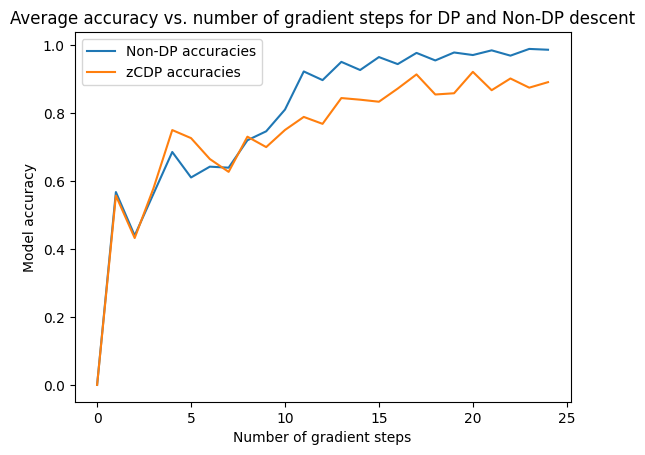

In [8]:
plt.plot([i for i in range(25)], non_DP_accuracies, label='Non-DP accuracies')
plt.plot([i for i in range(25)], zCDP_accuracies, label='zCDP accuracies')
plt.xlabel('Number of gradient steps')
plt.ylabel('Model accuracy')
plt.title('Average accuracy vs. number of gradient steps for DP and Non-DP descent')
plt.legend()
plt.show()

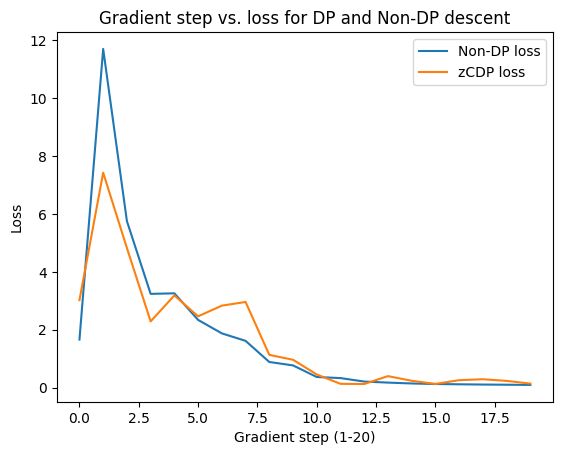

In [9]:
# compare non-DP, zCDP model losses for a given split of the data over 20 gradient steps each, same rho as above for zCDP
# shuffle first to keep it interesting!
X_train, X_test, y_train, y_test = re_shuffle(frisbee)
gradient_steps = 20
# non_DP gradient descent
theta_non_DP, losses_non_DP = gradient_descent(gradient_steps)
# DP gradient descent
theta_zCDP, losses_zCDP = gradient_descent_zCDP(gradient_steps, rho)
plt.plot([i for i in range(gradient_steps)], losses_non_DP, label='Non-DP loss')
plt.plot([i for i in range(gradient_steps)], losses_zCDP, label='zCDP loss')
plt.xlabel('Gradient step (1-20)')
plt.ylabel('Loss')
plt.title('Gradient step vs. loss for DP and Non-DP descent')
plt.legend()
plt.show()
# note, i think the peak at the beginning of the graph is due to an overshooting of the first step of the gradient descent-- 
# I'm no expert on these models, but if I had to guess why loss peaks here and THEN goes down (which is the expected behavior) I think thats why

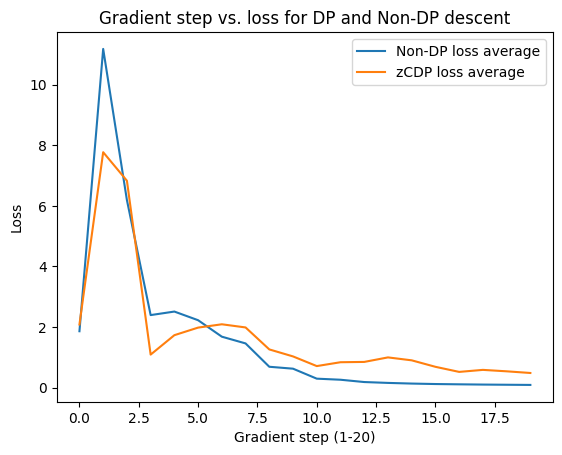

In [10]:
# averaged version over 10 trials of the previous graph:
gradient_steps = 20
trials = 10
# we initialize the average losses to all 0, so we dont get index out of bounds (cheeky, but works)
average_losses_non_DP = [0 for _ in range(gradient_steps)]
average_losses_zCDP = [0 for _ in range(gradient_steps)]
for _ in range(trials):
    X_train, X_test, y_train, y_test = re_shuffle(frisbee)
    # non_DP gradient descent
    theta_non_DP, losses_non_DP = gradient_descent(gradient_steps)
    # DP gradient descent
    theta_zCDP, losses_zCDP = gradient_descent_zCDP(gradient_steps, rho)
    average_losses_non_DP = [average_losses_non_DP[i] + losses_non_DP[i] for i in range(len(losses_non_DP))]
    average_losses_zCDP = [average_losses_zCDP[i] + losses_zCDP[i] for i in range(len(losses_zCDP))]
average_losses_non_DP = [average_loss / trials for average_loss in average_losses_non_DP]
average_losses_zCDP = [average_loss / trials for average_loss in average_losses_zCDP]
plt.plot([i for i in range(gradient_steps)], average_losses_non_DP, label='Non-DP loss average')
plt.plot([i for i in range(gradient_steps)], average_losses_zCDP, label='zCDP loss average')
plt.xlabel('Gradient step (1-20)')
plt.ylabel('Loss')
plt.title('Gradient step vs. loss for DP and Non-DP descent')
plt.legend()
plt.show()

In [69]:
# import the frisbee dataset
non_synth_frisbee = pd.read_csv('https://raw.githubusercontent.com/jbellizia/cs-3110-final/refs/heads/main/ultimate_college_championship.csv')

# discard player names and team names, as well as plus minus per game (we use plus minus kind of in the gradient descent)
non_synth_frisbee = non_synth_frisbee.drop(['player', 'level', 'gender', 'team_name', 'pls_mns_per_game', 'turns_per_game', 'ds_per_game', 'pts_per_game', 'ast_per_game'], axis = 1)

# Create a new column 'is_positive'
non_synth_frisbee['is_positive'] = (non_synth_frisbee['plus_minus'] > 0).astype(int)


In [75]:
def one_way_marginal(col, epsilon):
    hist = non_synth_frisbee[col].value_counts()
    noisy_hist = hist.apply(lambda x: laplace_mech(x, sensitivity=1, epsilon=epsilon))
    marginal = noisy_hist.clip(lower=0) / noisy_hist.clip(lower=0).sum()
    return marginal

def dp_two_marginal(col1, col2, epsilon):
    vals1 = non_synth_frisbee[col1].unique()
    vals2 = non_synth_frisbee[col2].unique()
    full_index = pd.MultiIndex.from_product([vals1, vals2], names=[col1, col2])
    hist = non_synth_frisbee[[col1, col2]].value_counts().reindex(full_index, fill_value=0)
    dp_hist = hist.apply(lambda x: laplace_mech(x, sensitivity=1, epsilon=epsilon))
    dp_hist = dp_hist.clip(lower=0)
    marginal = dp_hist / dp_hist.sum()
    return marginal.to_frame(name='probability').reset_index()

    
def sample_from_two_way(col1, col2, epsilon, given_value, n):
    joint = dp_two_marginal(col1, col2, epsilon)
    subset = joint[joint[col1] == given_value].copy()
    if subset['probability'].sum() == 0:
        subset['probability'] = 1
    subset['probability'] /= subset['probability'].sum()  # normalize
    return subset.sample(n=n, replace=True, weights='probability')[col2].reset_index(drop=True)

In [76]:
def generate_synthetic(n, epsilon):
    synthetic = {}
    div_marg = one_way_marginal('division', epsilon).rename_axis('division').to_frame(name='probability').reset_index()
    synthetic['division'] = div_marg.sample(n=n, replace=True, weights='probability')['division'].reset_index(drop=True)
    #now two way marginals with the columns turns, ds, assists, points, plus_minus, team_games
    columns_to_model = ['Turns', 'Ds', 'Assists', 'Points', 'plus_minus', 'team_games']

    for col in columns_to_model:
        synthetic[col] = [sample_from_two_way('division', col, epsilon, synthetic['division'][i], 1)[0] for i in range(n)]

    synthetic['turns_per_game'] = synthetic['Turns'] / pd.Series(synthetic['team_games']).clip(lower=1)
    synthetic['ds_per_game'] = synthetic['Ds'] / pd.Series(synthetic['team_games']).clip(lower=1)
    synthetic['ast_per_game'] = synthetic['Assists'] / pd.Series(synthetic['team_games']).clip(lower=1)

    synthetic['is_positive'] = [sample_from_two_way('plus_minus', 'is_positive', epsilon, synthetic['plus_minus'][i], 1)[0]for i in range(n)]
    
    return pd.DataFrame(synthetic)


cols = ['division', 'Turns', 'Ds', 'Assists', 'Points', 'plus_minus', 'team_games']
synth_data = generate_synthetic(len(non_synth_frisbee), epsilon=1)
synth_data

,division,Turns,Ds,Assists,Points,plus_minus,team_games,turns_per_game,ds_per_game,ast_per_game,is_positive
0,Division 1 Men,1,2,0,3,21,5,0.200,0.400000,0.000,1
1,Division 1 Women,6,1,12,0,5,6,1.000,0.166667,2.000,1
2,Division 1 Men,7,1,0,0,2,5,1.400,0.200000,0.000,1
3,Division 1 Men,1,1,0,10,3,5,0.200,0.200000,0.000,1
4,Division 1 Men,2,0,0,3,1,5,0.400,0.000000,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...
1660,Division 1 Men,8,18,10,0,0,5,1.600,3.600000,2.000,0
1661,Division 1 Men,1,0,1,2,8,8,0.125,0.000000,0.125,1
1662,Division 3 Women,10,6,0,4,1,5,2.000,1.200000,0.000,1
1663,Division 1 Women,0,1,1,4,-13,5,0.000,0.200000,0.200,0
